In [10]:
%pylab nbagg
from tvb.simulator.lab import *
import numpy

Populating the interactive namespace from numpy and matplotlib


# Tutorial: Modeling The Impact of Structural Lesions -- Part II: The Brain Network Model

In this tutorial we will show the steps required to build the network model used in [1]. First, the dynamics of the uncoupled network will be explored (ie, single node dynamics). Second, you can either run the script 'region_deterministic_modeling_structural_lesions.py' or execute the code cell to obtain some sample time-series. Running time for a complete 10 minutes long simulation using the 998 ROIs Hagmann connectome takes about 5 days, for an integration time step size of 0.2 ms. Even though empirical BOLD data length is in the order of ten of minutes, for the purposes of understanding the stages of this modeling pipeline we suggest to execute short simulations. 

In [11]:
lb = models.LarterBreakspear(QV_max=1.0, QZ_max=1.0, 
                             d_V=0.65, d_Z=0.65, 
                             aee=0.36, ani=0.4, ane=1.0)

lb.variables_of_interest = ["V", "W", "Z"]


white_matter = connectivity.Connectivity.from_file("connectivity_66.zip")
white_matter.speed = numpy.array([7.0])

white_matter_coupling = coupling.HyperbolicTangent(a=0.5*lb.QV_max, 
                                                   midpoint=lb.VT, 
                                                   sigma=lb.d_V,)

#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=0.2)

#Initialise some Monitors with period in physical time
mon_tavg =  monitors.TemporalAverage(period=2.)
mon_bold  = monitors.Bold(period=2000.)

#Bundle them
what_to_watch = (mon_bold, mon_tavg)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = lb, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, 
                          monitors = what_to_watch)

sim.configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


Simulator(bound=False, value=None)

In [4]:
LOG.info("Starting simulation...")
#Perform the simulation
bold_data, bold_time = [], []
tavg_data, tavg_time = [], []

for raw, tavg in sim(simulation_length=2000):
    if not raw is None:
        bold_time.append(raw[0])
        bold_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

LOG.info("Finished simulation.")

   INFO  Starting simulation...
   INFO  Finished simulation.


In [5]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


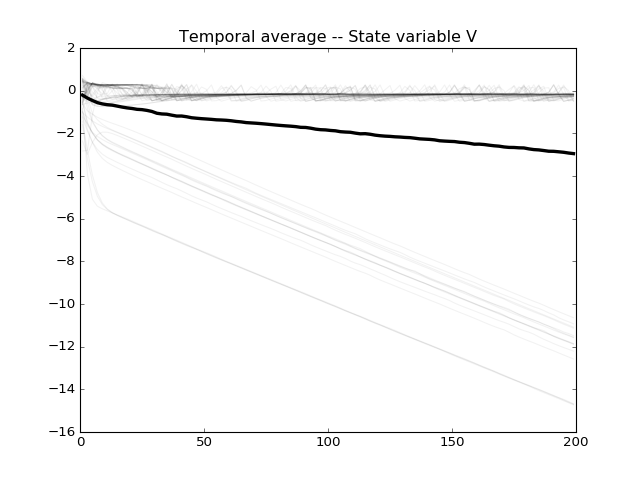

<IPython.core.display.Javascript object>


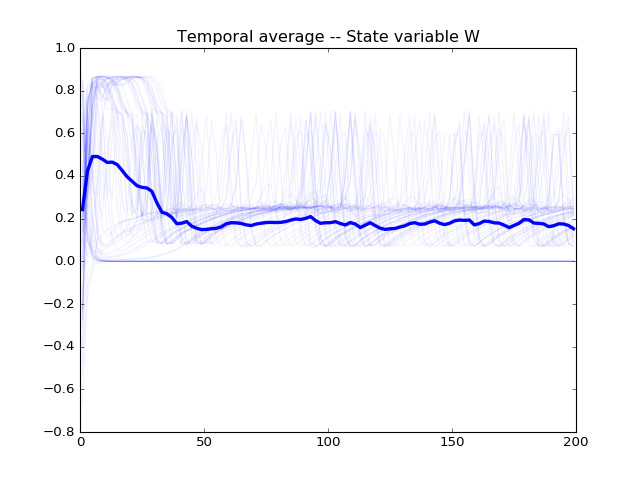

<IPython.core.display.Javascript object>


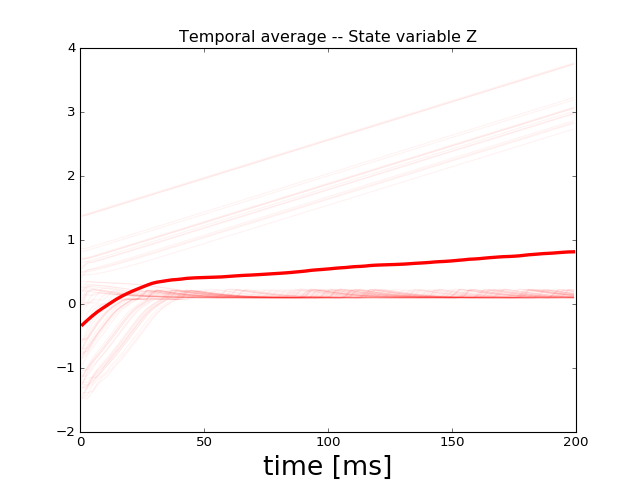

In [6]:
#Make the lists numpy.arrays for easier use.
BOLD = numpy.array(bold_data)
TAVG = numpy.array(tavg_data)
tavg_time = numpy.array(tavg_time)
t_interval=numpy.arange(100)

#Plot raw time series
figure(1)
plot(tavg_time[t_interval], TAVG[t_interval, 0, :, 0], 'k', alpha=0.05)
plot(tavg_time[t_interval], TAVG[t_interval, 0, :, 0].mean(axis=1), 'k',  linewidth=3)
title("Temporal average -- State variable V")

figure(2)
plot(tavg_time[t_interval], TAVG[t_interval, 1, :, 0], 'b', alpha=0.05)
plot(tavg_time[t_interval], TAVG[t_interval, 1, :, 0].mean(axis=1), 'b', linewidth=3)
title("Temporal average -- State variable W")

figure(3)
plot(tavg_time[t_interval], TAVG[t_interval, 2, :, 0], 'r', alpha=0.05)
plot(tavg_time[t_interval], TAVG[t_interval, 2, :, 0].mean(axis=1), 'r', linewidth=3)
title("Temporal average -- State variable Z")
xlabel('time [ms]', fontsize=24)


<IPython.core.display.Javascript object>


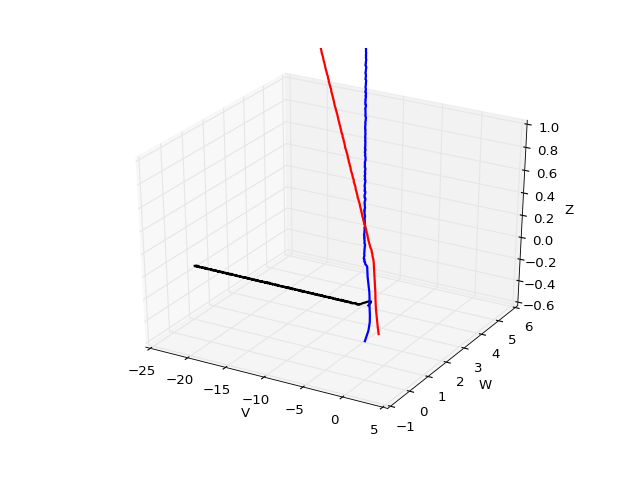

In [7]:
#Plot 3D trajectories
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(4)
ax = fig.gca(projection='3d')


ax.plot(TAVG[:, 0, :, 0].mean(axis=1),  TAVG[:, 1, :, 0].mean(axis=1), 'k', zs=0.0, zdir='z', linewidth=2)
ax.plot(TAVG[:, 1, :, 0].mean(axis=1),  TAVG[:, 2, :, 0].mean(axis=1), 'b', zdir='x', zs=-0.6,linewidth=2)
ax.plot(TAVG[:, 0, :, 0].mean(axis=1),  TAVG[:, 2, :, 0].mean(axis=1), 'r', zdir='y', zs=0.8,linewidth=2)
ax.set_xlabel('V')
ax.set_ylabel('W')
ax.set_zlabel('Z')
plt.show()


<IPython.core.display.Javascript object>


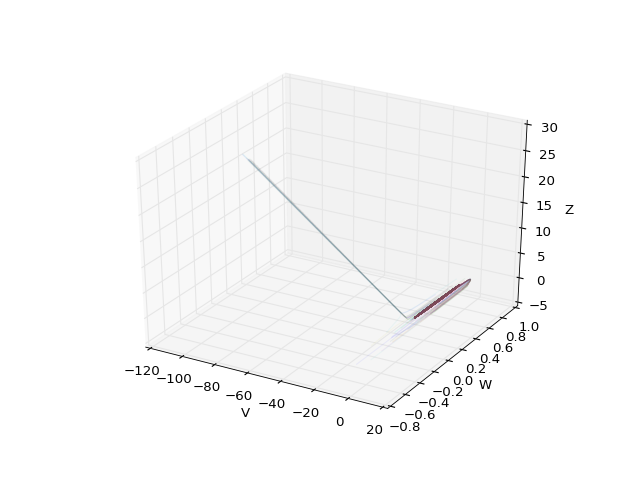

In [8]:
fig = plt.figure(6)
ax = fig.gca(projection='3d')


for node in range(white_matter.number_of_regions):
    ax.plot(TAVG[:, 0, node, 0], TAVG[:, 1, node, 0], TAVG[:, 2, node, 0], alpha=0.05)


ax.set_xlabel('V')
ax.set_ylabel('W')
ax.set_zlabel('Z')


[1] Alstott et al. (2009) Modeling the impact of lesions in the human brain. Plos Comp Bio.
